digraph {
	__start__
	retrieve_similar_selections
	relevant_selections
	get_schema
	query_gen
	reflect
	format_answer
	submit_final_answer
	save
	__end__
	__start__ -> retrieve_similar_selections
	format_answer -> submit_final_answer
	get_schema -> query_gen
	query_gen -> format_answer
	query_gen -> reflect
	reflect -> format_answer
	reflect -> query_gen
	relevant_selections -> get_schema
	retrieve_similar_selections -> relevant_selections
	submit_final_answer -> save
	save -> __end__
}



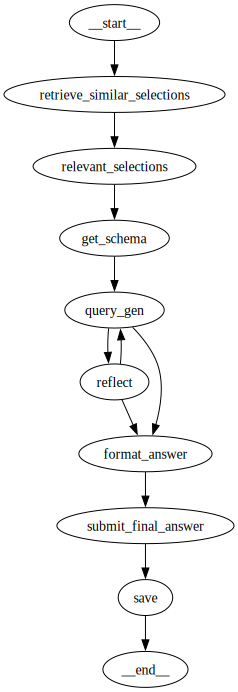

In [1]:
from IPython.display import Image, display, SVG
import graphviz
from my_agent import create_graph

# Create graph instance
app = create_graph()

# Convert to graphviz
dot = graphviz.Digraph()
for node in app.get_graph().nodes:
    dot.node(str(node))

for edge in app.get_graph().edges:
    if not (edge[0] == "query_gen" and edge[1] == "__end__"):
        if edge == ("query_gen", "format_answer"):
            dot.edge(
                str(edge[0]), str(edge[1]),
                label="max_iter",
                fontcolor="red",
                fontsize="20",
                style="bold",
                decorate="true",
                tooltip="This edge is used when max_iter is reached"
            )
        else:
            dot.edge(str(edge[0]), str(edge[1]))

# Print DOT source for debugging
print(dot.source)

# Display the graph (try SVG for best label rendering)
# display(Image(dot.pipe(format='png')))
# Or, for SVG (uncomment the next line if you want SVG output)
display(SVG(dot.pipe(format='svg')))

In [2]:
from IPython.display import Image, display, SVG
import graphviz
from my_agent import create_graph
import asyncio
import nest_asyncio

# Allow nested event loops in Jupyter
nest_asyncio.apply()

# Create graph instance
app = await create_graph()

# Convert to graphviz
dot = graphviz.Digraph()
for node in app.get_graph().nodes:
    dot.node(str(node))

for edge in app.get_graph().edges:
    if not (edge[0] == "query_gen" and edge[1] == "__end__"):
        if edge == ("query_gen", "format_answer"):
            dot.edge(
                str(edge[0]), str(edge[1]),
                label="max_iter",
                fontcolor="red",
                fontsize="20",
                style="bold",
                decorate="true",
                tooltip="This edge is used when max_iter is reached"
            )
        else:
            dot.edge(str(edge[0]), str(edge[1]))

# Print DOT source for debugging
print(dot.source)

# Display the graph (try SVG for best label rendering)
# display(Image(dot.pipe(format='png')))
# Or, for SVG (uncomment the next line if you want SVG output)
display(SVG(dot.pipe(format='svg')))

TypeError: object CompiledStateGraph can't be used in 'await' expression

In [ ]:
from IPython.display import Image, display, SVG
import graphviz
from my_agent import create_graph
import asyncio
import nest_asyncio

# Allow nested event loops in Jupyter
nest_asyncio.apply()

# Create graph instance
app = await create_graph()

# Convert to graphviz
dot = graphviz.Digraph()
for node in app.get_graph().nodes:
    dot.node(str(node))

for edge in app.get_graph().edges:
    if not (edge[0] == "query_gen" and edge[1] == "__end__"):
        if edge == ("query_gen", "format_answer"):
            dot.edge(
                str(edge[0]), str(edge[1]),
                label="max_iter",
                fontcolor="red",
                fontsize="20",
                style="bold",
                decorate="true",
                tooltip="This edge is used when max_iter is reached"
            )
        else:
            dot.edge(str(edge[0]), str(edge[1]))

# Print DOT source for debugging
print(dot.source)

# Display the graph (try SVG for best label rendering)
# display(Image(dot.pipe(format='png')))
# Or, for SVG (uncomment the next line if you want SVG output)
display(SVG(dot.pipe(format='svg')))

DEBUG:my_agent.agent:Fetching MCP tools...
DEBUG:my_agent.utils.mcp_tools:MCP server started using subprocess.
DEBUG:my_agent.utils.mcp_tools:MCP client initialized successfully.
DEBUG:my_agent.utils.mcp_tools:Attempting to fetch tools from MCP client...
ERROR:my_agent.utils.mcp_tools:Failed to fetch tools: 


NotImplementedError: 

In [ ]:
from IPython.display import Image, display, SVG
import graphviz
from my_agent import create_graph
import asyncio
import nest_asyncio

# Allow nested event loops in Jupyter
nest_asyncio.apply()

# Create graph instance
app = await create_graph()

# Convert to graphviz
dot = graphviz.Digraph()
for node in app.get_graph().nodes:
    dot.node(str(node))

for edge in app.get_graph().edges:
    if not (edge[0] == "query_gen" and edge[1] == "__end__"):
        if edge == ("query_gen", "format_answer"):
            dot.edge(
                str(edge[0]), str(edge[1]),
                label="max_iter",
                fontcolor="red",
                fontsize="20",
                style="bold",
                decorate="true",
                tooltip="This edge is used when max_iter is reached"
            )
        else:
            dot.edge(str(edge[0]), str(edge[1]))

# Print DOT source for debugging
print(dot.source)

# Display the graph (try SVG for best label rendering)
# display(Image(dot.pipe(format='png')))
# Or, for SVG (uncomment the next line if you want SVG output)
display(SVG(dot.pipe(format='svg')))

DEBUG:my_agent.agent:Fetching MCP tools...
DEBUG:my_agent.utils.mcp_tools:MCP server started using subprocess.
DEBUG:my_agent.utils.mcp_tools:MCP client initialized successfully.
DEBUG:my_agent.utils.mcp_tools:Attempting to fetch tools from MCP client...
ERROR:my_agent.utils.mcp_tools:Failed to fetch tools: 


NotImplementedError: 

In [ ]:
from IPython.display import Image, display, SVG
import graphviz
from my_agent import create_graph
import asyncio
import nest_asyncio

# Allow nested event loops in Jupyter
nest_asyncio.apply()

# Create graph instance
app = await create_graph()

# Convert to graphviz
dot = graphviz.Digraph()
for node in app.get_graph().nodes:
    dot.node(str(node))

for edge in app.get_graph().edges:
    if not (edge[0] == "query_gen" and edge[1] == "__end__"):
        if edge == ("query_gen", "format_answer"):
            dot.edge(
                str(edge[0]), str(edge[1]),
                label="max_iter",
                fontcolor="red",
                fontsize="20",
                style="bold",
                decorate="true",
                tooltip="This edge is used when max_iter is reached"
            )
        else:
            dot.edge(str(edge[0]), str(edge[1]))

# Print DOT source for debugging
print(dot.source)

# Display the graph (try SVG for best label rendering)
# display(Image(dot.pipe(format='png')))
# Or, for SVG (uncomment the next line if you want SVG output)
display(SVG(dot.pipe(format='svg')))

DEBUG:my_agent.agent:Fetching MCP tools...
DEBUG:my_agent.utils.mcp_tools:MCP server started using subprocess.
DEBUG:my_agent.utils.mcp_tools:MCP client initialized successfully.
DEBUG:my_agent.utils.mcp_tools:Attempting to fetch tools from MCP client...
ERROR:my_agent.utils.mcp_tools:Failed to fetch tools: 


NotImplementedError: 

In [ ]:
from IPython.display import Image, display, SVG
import graphviz
from my_agent import create_graph
import asyncio
import nest_asyncio

# Allow nested event loops in Jupyter
nest_asyncio.apply()

# Create graph instance
app = await create_graph()

# Convert to graphviz
dot = graphviz.Digraph()
for node in app.get_graph().nodes:
    dot.node(str(node))

for edge in app.get_graph().edges:
    if not (edge[0] == "query_gen" and edge[1] == "__end__"):
        if edge == ("query_gen", "format_answer"):
            dot.edge(
                str(edge[0]), str(edge[1]),
                label="max_iter",
                fontcolor="red",
                fontsize="20",
                style="bold",
                decorate="true",
                tooltip="This edge is used when max_iter is reached"
            )
        else:
            dot.edge(str(edge[0]), str(edge[1]))

# Print DOT source for debugging
print(dot.source)

# Display the graph (try SVG for best label rendering)
# display(Image(dot.pipe(format='png')))
# Or, for SVG (uncomment the next line if you want SVG output)
display(SVG(dot.pipe(format='svg')))

DEBUG:my_agent.agent:Fetching MCP tools...
DEBUG:my_agent.utils.mcp_tools:MCP server started using subprocess.
DEBUG:my_agent.utils.mcp_tools:MCP client initialized successfully.
DEBUG:my_agent.utils.mcp_tools:Attempting to fetch tools from MCP client...
ERROR:my_agent.utils.mcp_tools:Failed to fetch tools: 


NotImplementedError: 

In [ ]:
from IPython.display import Image, display, SVG
import graphviz
from my_agent import create_graph
import asyncio
import nest_asyncio

# Allow nested event loops in Jupyter
nest_asyncio.apply()

# Create graph instance
app = await create_graph()

# Convert to graphviz
dot = graphviz.Digraph()
for node in app.get_graph().nodes:
    dot.node(str(node))

for edge in app.get_graph().edges:
    if not (edge[0] == "query_gen" and edge[1] == "__end__"):
        if edge == ("query_gen", "format_answer"):
            dot.edge(
                str(edge[0]), str(edge[1]),
                label="max_iter",
                fontcolor="red",
                fontsize="20",
                style="bold",
                decorate="true",
                tooltip="This edge is used when max_iter is reached"
            )
        else:
            dot.edge(str(edge[0]), str(edge[1]))

# Print DOT source for debugging
print(dot.source)

# Display the graph (try SVG for best label rendering)
# display(Image(dot.pipe(format='png')))
# Or, for SVG (uncomment the next line if you want SVG output)
display(SVG(dot.pipe(format='svg')))

DEBUG:my_agent.agent:Fetching MCP tools...
DEBUG:my_agent.utils.mcp_tools:MCP server started using subprocess.
DEBUG:my_agent.utils.mcp_tools:MCP client initialized successfully.
DEBUG:my_agent.utils.mcp_tools:Attempting to fetch tools from MCP client...
ERROR:my_agent.utils.mcp_tools:Failed to fetch tools: 


NotImplementedError: 

In [ ]:
from IPython.display import Image, display, SVG
import graphviz
from my_agent import create_graph
import asyncio
import nest_asyncio

# Allow nested event loops in Jupyter
nest_asyncio.apply()

# Create graph instance
app = await create_graph()

# Convert to graphviz
dot = graphviz.Digraph()
for node in app.get_graph().nodes:
    dot.node(str(node))

for edge in app.get_graph().edges:
    if not (edge[0] == "query_gen" and edge[1] == "__end__"):
        if edge == ("query_gen", "format_answer"):
            dot.edge(
                str(edge[0]), str(edge[1]),
                label="max_iter",
                fontcolor="red",
                fontsize="20",
                style="bold",
                decorate="true",
                tooltip="This edge is used when max_iter is reached"
            )
        else:
            dot.edge(str(edge[0]), str(edge[1]))

# Print DOT source for debugging
print(dot.source)

# Display the graph (try SVG for best label rendering)
# display(Image(dot.pipe(format='png')))
# Or, for SVG (uncomment the next line if you want SVG output)
display(SVG(dot.pipe(format='svg')))

DEBUG:my_agent.agent:Fetching MCP tools...
DEBUG:my_agent.utils.mcp_tools:MCP server started using subprocess.
DEBUG:my_agent.utils.mcp_tools:MCP client initialized successfully.
DEBUG:my_agent.utils.mcp_tools:Attempting to fetch tools from MCP client...
ERROR:my_agent.utils.mcp_tools:Failed to fetch tools: 


NotImplementedError: 

In [ ]:
from IPython.display import Image, display, SVG
import graphviz
from my_agent import create_graph
import asyncio
import nest_asyncio

# Allow nested event loops in Jupyter
nest_asyncio.apply()

# Create graph instance
app = await create_graph()

# Convert to graphviz
dot = graphviz.Digraph()
for node in app.get_graph().nodes:
    dot.node(str(node))

for edge in app.get_graph().edges:
    if not (edge[0] == "query_gen" and edge[1] == "__end__"):
        if edge == ("query_gen", "format_answer"):
            dot.edge(
                str(edge[0]), str(edge[1]),
                label="max_iter",
                fontcolor="red",
                fontsize="20",
                style="bold",
                decorate="true",
                tooltip="This edge is used when max_iter is reached"
            )
        else:
            dot.edge(str(edge[0]), str(edge[1]))

# Print DOT source for debugging
print(dot.source)

# Display the graph (try SVG for best label rendering)
# display(Image(dot.pipe(format='png')))
# Or, for SVG (uncomment the next line if you want SVG output)
display(SVG(dot.pipe(format='svg')))

DEBUG:my_agent.agent:Fetching MCP tools...
DEBUG:my_agent.utils.mcp_tools:MCP server started using subprocess.
DEBUG:my_agent.utils.mcp_tools:MCP client initialized successfully.
DEBUG:my_agent.utils.mcp_tools:Attempting to fetch tools from MCP client...
ERROR:my_agent.utils.mcp_tools:Failed to fetch tools: 


NotImplementedError: 

In [ ]:
from IPython.display import Image, display, SVG
import graphviz
from my_agent import create_graph
import asyncio
import nest_asyncio

# Allow nested event loops in Jupyter
nest_asyncio.apply()

# Create graph instance
app = await create_graph()

# Convert to graphviz
dot = graphviz.Digraph()
for node in app.get_graph().nodes:
    dot.node(str(node))

for edge in app.get_graph().edges:
    if not (edge[0] == "query_gen" and edge[1] == "__end__"):
        if edge == ("query_gen", "format_answer"):
            dot.edge(
                str(edge[0]), str(edge[1]),
                label="max_iter",
                fontcolor="red",
                fontsize="20",
                style="bold",
                decorate="true",
                tooltip="This edge is used when max_iter is reached"
            )
        else:
            dot.edge(str(edge[0]), str(edge[1]))

# Print DOT source for debugging
print(dot.source)

# Display the graph (try SVG for best label rendering)
# display(Image(dot.pipe(format='png')))
# Or, for SVG (uncomment the next line if you want SVG output)
display(SVG(dot.pipe(format='svg')))

DEBUG:my_agent.agent:Fetching MCP tools...
DEBUG:my_agent.utils.mcp_tools:MCP server started using subprocess.
DEBUG:my_agent.utils.mcp_tools:MCP client initialized successfully.
DEBUG:my_agent.utils.mcp_tools:Attempting to fetch tools from MCP client...
ERROR:my_agent.utils.mcp_tools:Failed to fetch tools: 


NotImplementedError: 

In [ ]:
from IPython.display import Image, display, SVG
import graphviz
from my_agent import create_graph
import asyncio
import nest_asyncio

# Allow nested event loops in Jupyter
nest_asyncio.apply()

# Create graph instance
app = await create_graph()

# Convert to graphviz
dot = graphviz.Digraph()
for node in app.get_graph().nodes:
    dot.node(str(node))

for edge in app.get_graph().edges:
    if not (edge[0] == "query_gen" and edge[1] == "__end__"):
        if edge == ("query_gen", "format_answer"):
            dot.edge(
                str(edge[0]), str(edge[1]),
                label="max_iter",
                fontcolor="red",
                fontsize="20",
                style="bold",
                decorate="true",
                tooltip="This edge is used when max_iter is reached"
            )
        else:
            dot.edge(str(edge[0]), str(edge[1]))

# Print DOT source for debugging
print(dot.source)

# Display the graph (try SVG for best label rendering)
# display(Image(dot.pipe(format='png')))
# Or, for SVG (uncomment the next line if you want SVG output)
display(SVG(dot.pipe(format='svg')))

DEBUG:my_agent.agent:Fetching MCP tools...
DEBUG:my_agent.utils.mcp_tools:MCP server started using subprocess.
DEBUG:my_agent.utils.mcp_tools:MCP client initialized successfully.
DEBUG:my_agent.utils.mcp_tools:Attempting to fetch tools from MCP client...
ERROR:my_agent.utils.mcp_tools:Failed to fetch tools: 


NotImplementedError: 

In [ ]:
from my_agent import create_graph

def visualize_graph_text():
    # Create graph instance
    app = create_graph()
    graph = app.get_graph()
    
    # Get all nodes and edges
    nodes = list(graph.nodes)
    edges = list(graph.edges)
    
    # Print nodes
    print("Nodes:")
    for node in nodes:
        print(f"  - {node}")
    
    # Print edges
    print("\nEdges:")
    for edge in edges:
        if not (edge[0] == "query_gen" and edge[1] == "__end__"):
            print(f"  {edge[0]} -> {edge[1]}")

if __name__ == "__main__":
    visualize_graph_text()